# Tutorial: Accessing and manipulating data 

#### This notebook was developed by [Zeljko Ivezic](http://faculty.washington.edu/ivezic/)  for the Vatican Observatory Summer School 2023, and it is available from [github](https://github.com/ivezic/IRB2023/blob/main/notebooks/IRBclass2.ipynb).

The Zwicky Transient Factory example was kindly provided by Mathew Graham.

[On the IRSA page](https://irsa.ipac.caltech.edu/frontpage/)
there is a Login link on the top right where you can create an IRSA account (that is needed to access data).

## Example: LINEAR (from astroML) and ZTF (from IRSA) light curves <a id='ML1'></a>
[Go to top](#toc)

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.stats import norm
np.random.seed(42)
%matplotlib inline  

In [2]:
from astroML.utils.decorators import pickle_results
from astroML.time_series import search_frequencies, lomb_scargle, MultiTermFit
from astroML.datasets import fetch_LINEAR_sample

In [62]:
#------------------------------------------------------------
# Load the dataset
data = fetch_LINEAR_sample()
ids = [14752041, 1009459, 10022663, 10025796, 11375941, 18525697]

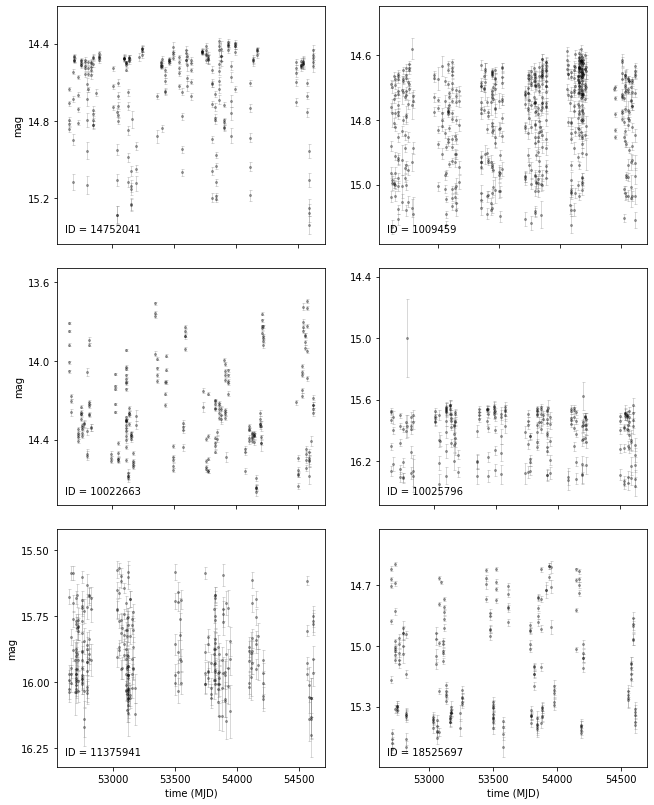

In [16]:
#------------------------------------------------------------
# Plot light curves: magnitude vs. time
fig = plt.figure(figsize=(10, 12))
fig.subplots_adjust(hspace=0.1, bottom=0.06, top=0.94, left=0.12, right=0.94)

for i in range(6):
    # get the data and best-fit angular frequency
    t, y, dy = data[ids[i]].T

    # plot mag(time) data  
    ax = fig.add_subplot(321 + i)
    ax.errorbar(t, y, dy, fmt='.k', ecolor='gray',
                lw=1, ms=4, capsize=1.5, alpha=0.3)

    #ax.set_xlim(0, 1)
    ax.set_ylim(plt.ylim()[::-1])
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    ax.text(0.03, 0.04, "ID = %i" % ids[i], ha='left', va='bottom',
            transform=ax.transAxes)

    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], ylim[0] + 1.1 * (ylim[1] - ylim[0]))

    if i < 4:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    if i % 2 == 0:
        ax.set_ylabel('mag')

    if i in (4, 5):
        ax.set_xlabel('time (MJD)')

plt.show()

In [5]:
#------------------------------------------------------------
# Compute the best frequencies
@pickle_results('LINEAR_LS.pkl')
def compute_best_frequencies(ids, n_eval=10000, n_retry=5, generalized=True):
    results = {}
    for i in ids:
        t, y, dy = data[i].T
        print(" - computing power for {0} ({1} points)".format(i, len(t)))
        kwargs = dict(generalized=generalized)
        omega, power = search_frequencies(t, y, dy, n_eval=n_eval,
                                          n_retry=n_retry,
                                          LS_kwargs=kwargs)
        results[i] = [omega, power]

    return results

In [6]:
results = compute_best_frequencies(ids, n_eval=10000, n_retry=5)

@pickle_results: computing results and saving to 'LINEAR_LS.pkl'
 - computing power for 14752041 (253 points)
 - computing power for 1009459 (593 points)
 - computing power for 10022663 (246 points)
 - computing power for 10025796 (233 points)
 - computing power for 11375941 (280 points)
 - computing power for 18525697 (211 points)


 - omega_0 = 17.21695506
 - omega_0 = 51.10600808
 - omega_0 = 10.20062676
 - omega_0 = 45.55493503
 - omega_0 = 58.44512277
 - omega_0 = 10.82722772


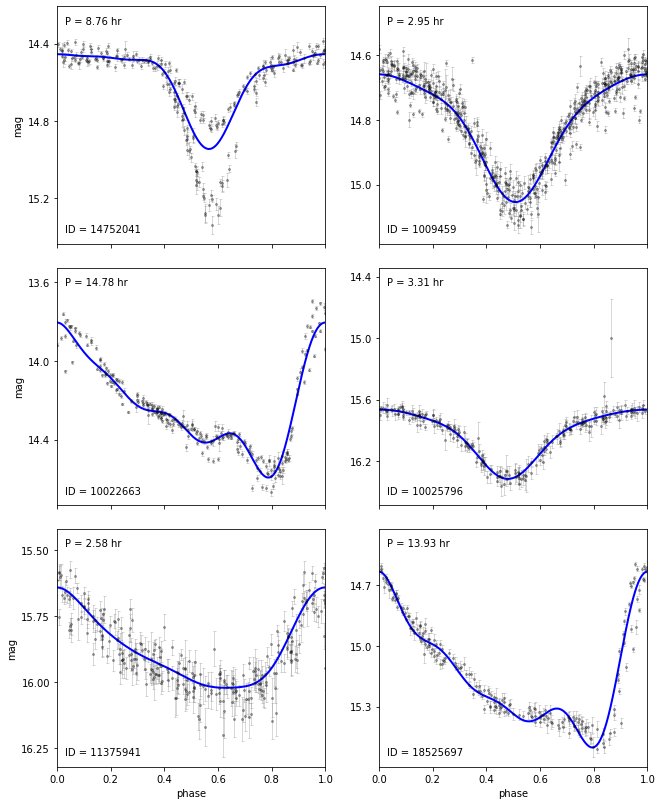

In [9]:
#------------------------------------------------------------
# Plot the phased light-curves
fig = plt.figure(figsize=(10, 12))
fig.subplots_adjust(hspace=0.1, bottom=0.06, top=0.94, left=0.12, right=0.94)

for i in range(6):
    # get the data and best-fit angular frequency
    t, y, dy = data[ids[i]].T
    omega, power = results[ids[i]]
    omega_best = omega[np.argmax(power)]
    print(" - omega_0 = %.10g" % omega_best)

    # do a fit to the first 4 Fourier components
    mtf = MultiTermFit(omega_best, 4)
    mtf.fit(t, y, dy)
    phase_fit, y_fit, phased_t = mtf.predict(1000, return_phased_times=True)

    # plot the phased data and best-fit curves
    ax = fig.add_subplot(321 + i)
    ax.errorbar(phased_t, y, dy, fmt='.k', ecolor='gray',
                lw=1, ms=4, capsize=1.5, alpha=0.3)
    ax.plot(phase_fit, y_fit, 'b', markeredgecolor='b', lw=2, fillstyle='top', linestyle='solid')

    ax.set_xlim(0, 1)
    ax.set_ylim(plt.ylim()[::-1])
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    ax.text(0.03, 0.04, "ID = %i" % ids[i], ha='left', va='bottom',
            transform=ax.transAxes)
    ax.text(0.03, 0.96, "P = %.2f hr" % (2 * np.pi / omega_best * 24.),
            ha='left', va='top',
            transform=ax.transAxes)

    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], ylim[0] + 1.1 * (ylim[1] - ylim[0]))

    if i < 4:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    if i % 2 == 0:
        ax.set_ylabel('mag')

    if i in (4, 5):
        ax.set_xlabel('phase')

plt.show()

In [14]:
time, mag, magErr = data[14752041].T

In [17]:
from ztfquery import lightcurve

In [24]:
def getZTFlightcurve(ra, dec, radius=3.0):
    # matching radius is given in arcsec
    try:
       lcq = lightcurve.LCQuery()
       res = lcq.from_position(ra, dec, radius)
       ZTFdata = res.data # this is basically a DataFrame then
       # M. Graham recommends to get rid of obvious spurious points
       #ZTFdata = ZTFdata.loc[data['catflags'] < 32768]
    except Exception as e:
       print(e)
    return ZTFdata

In [49]:
# for LINEAR ID = 11375941 
ra = 215.39626 # in decimal degrees
dec = 19.40012 # in decimal degrees
LC = getZTFlightcurve(ra, dec)

In [50]:
LC

,oid,expid,hjd,mjd,mag,magerr,catflags,filtercode,ra,dec,...,ccdid,qid,limitmag,magzp,magzprms,clrcoeff,clrcounc,exptime,airmass,programid
0,580111400002709,44835652,2.458203e+06,58202.356528,15.940124,0.012019,0,zg,215.396164,19.400038,...,0xb,0x4,20.940001,26.310677,0.029533,-0.025088,0.000022,30,1.099,1
1,580111400002709,45134217,2.458206e+06,58205.342176,15.690062,0.011659,0,zg,215.396173,19.400034,...,0xb,0x4,20.040001,26.134621,0.041739,-0.039952,0.000073,30,1.114,1
2,580111400002709,45136499,2.458206e+06,58205.365000,15.923037,0.011989,0,zg,215.396161,19.400042,...,0xb,0x4,20.139999,26.163576,0.035849,-0.021956,0.000053,30,1.067,1
3,580111400002709,45433996,2.458209e+06,58208.339965,15.570519,0.011542,32768,zg,215.396132,19.400060,...,0xb,0x4,19.070000,26.145845,0.045802,-0.011555,0.000223,30,1.100,1
4,580111400002709,45438877,2.458209e+06,58208.388773,15.991188,0.012115,32768,zg,215.396169,19.400044,...,0xb,0x4,18.500000,25.846258,0.048047,0.031892,0.000415,30,1.036,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1083,1625202400001888,158529103,2.459340e+06,59339.291030,15.653739,0.012196,0,zr,215.396189,19.400006,...,0x2,0x4,21.690001,26.208361,0.023063,0.109462,0.000013,30,1.019,2
1084,1625202400001888,158529150,2.459340e+06,59339.291505,15.648931,0.012186,0,zr,215.396183,19.400006,...,0x2,0x4,21.660000,26.222536,0.022633,0.102639,0.000012,30,1.019,3
1085,1625202400001888,158722613,2.459342e+06,59341.226134,15.655288,0.012199,0,zr,215.396192,19.400016,...,0x2,0x4,21.719999,26.215975,0.023900,0.099336,0.000014,30,1.095,2
1086,1625202400001888,158722659,2.459342e+06,59341.226597,15.650432,0.012189,0,zr,215.396186,19.400006,...,0x2,0x4,21.709999,26.220098,0.022996,0.101204,0.000013,30,1.094,3


In [38]:
t = LC['mjd']
mag = LC['mjd']

0      58280.443715
1      58286.441944
2      58289.435891
3      58292.440509
4      58305.478646
           ...     
191    59130.279965
192    59130.280428
193    59139.264375
194    59141.179479
195    59141.179942
Name: mjd, Length: 196, dtype: float64

In [51]:
LCg = LC.loc[LC['filtercode'] == 'zg']
LCr = LC.loc[LC['filtercode'] == 'zr']
LCi = LC.loc[LC['filtercode'] == 'zi']

In [70]:
# ZTF data in the g band
tZ = LCg['mjd']
magZ = LCg['mag']
magErrZ = LCg['magerr']

# LINEAR data
tL, mL, dmL = data[11375941].T

<ErrorbarContainer object of 3 artists>

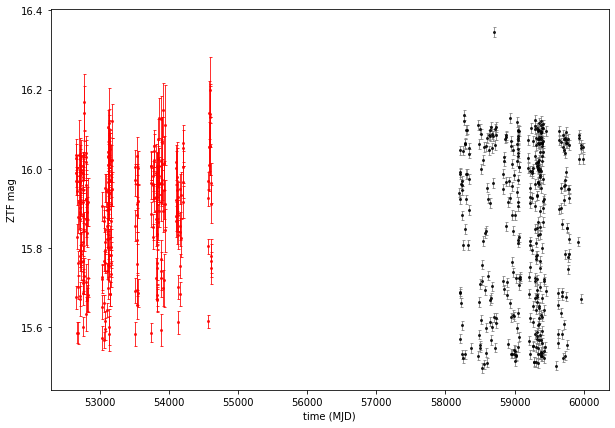

In [79]:
fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.set_xlabel('time (MJD)')
ax.set_ylabel('ZTF mag')
ax.scatter(t, mag, s=0.02, c='black')  
ax.errorbar(tZ, magZ, magErrZ, fmt='.k', ecolor='gray', lw=1, ms=4, capsize=1.5, alpha=0.8)
ax.errorbar(tL, mL, dmL, fmt='.r', ecolor='red', lw=1, ms=4, capsize=1.5, alpha=0.8)

#ax.set_ylim(16.5, 15.2)

In [75]:
omega, power = results[11375941]
omega_best = omega[np.argmax(power)]
print(" - omega_0 = %.10g" % omega_best)

# do a fit to the first 4 Fourier components for LINEAR data
mtfL = MultiTermFit(omega_best, 4)
mtfL.fit(tL, mL, dmL)
phaseL, mfitL, phasedtL = mtfL.predict(1000, return_phased_times=True)

# do a fit to the first 4 Fourier components for ZTF data
mtfZ = MultiTermFit(omega_best, 4)
mtfZ.fit(tZ, magZ, magErrZ)
phaseZ, mfitZ, phasedtZ = mtfZ.predict(1000, return_phased_times=True)

 - omega_0 = 58.44512277


(16.3, 15.4)

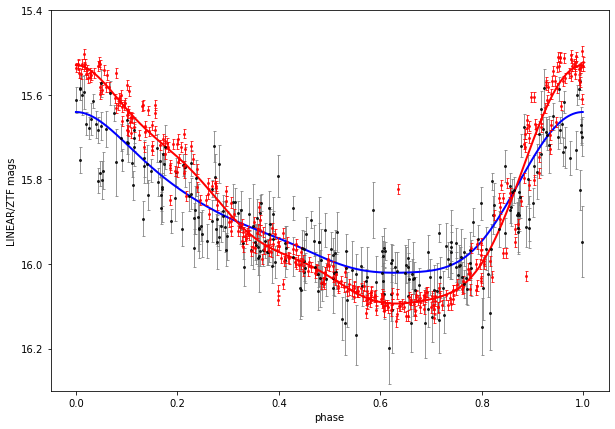

In [78]:
fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.set_xlabel('phase')
ax.set_ylabel('LINEAR/ZTF mags')

# LINEAR data
ax.errorbar(phasedtL, mL, dmL, fmt='.k', ecolor='gray', lw=1, ms=4, capsize=1.5, alpha=0.8)
ax.plot(phaseL, mfitL, 'b', markeredgecolor='b', lw=2, fillstyle='top', linestyle='solid')
# ZTF data
ax.errorbar(phasedtZ, magZ, magErrZ, fmt='.r', ecolor='red', lw=1, ms=4, capsize=1.5, alpha=0.8)
ax.plot(phaseZ, mfitZ, 'r', markeredgecolor='r', lw=2, fillstyle='top', linestyle='solid')


ax.set_ylim(16.3, 15.4)

## Why are these phased light curves different? 

While in principle RR Lyrae stars can modify their behavior on time scales of 10 years (the so-called Blazhko effect), here almost certainly the difference is due to bandpass differences between the LINEAR bandpass (no filter, essentially white light) and the ZTF g band. 

## Exercise for you: recycle the code above to produce a similar plot that compares the light curves in the ZTF g, r and i bands.

## Example: data from NOIRLab's Data Lab <a id='Gaia'></a>
[Go to top](#toc)